# Differentially Private Deep Learning with Opacus

Adapted from  https://github.com/pytorch/opacus/blob/main/tutorials/intro_to_advanced_features.ipynb

In this document, we will investigate the advanced features of Opacus and see how to implement custom functionality.

First of all, we recommend you get a GPU runtime for this Colab! You can do so by clicking on Runtime > Change Runtime Type above, and selecting GPU.

First things first: let's start by installing Opacus.

## Overview

There are three components essential to DP-SGD.

  
1. The norm of the gradient value for every sample is clipped to a certain value
  
2. Calibrated gaussian noise is added to the resulting batch gradient to hide the individual contributions.

3. Minibatches should be formed by uniform sampling, i.e. on each training step, each sample from the dataset is included with a certain probability `q`. Note, that this is different from standard approach of dataset being shuffled and split into batches: each sample has a non-zero probability of appearing multiple times in a given epoch, or not appearing at all.


This translates into the three distinctions from standard training:

1. We need to compute per sample gradients (so that we know what to clip). Currently, PyTorch autograd engine only stores gradients aggregated over a batch.
2. We need to incorporate Poisson sampling into the training process.
3. We need to implement gradient clipping and noise addition
4. Finally, we need to keep an account of the privacy parameter.

In [45]:
!pip install opacus
%env PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512

env: PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512


In [46]:
# Usual suspects
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.autonotebook import tqdm

# Our shiny cool lib
import opacus

# Part 0: Prerequistes

## Let's load the training data
Our task: **train a CIFAR10 model with differential privacy.**



In [47]:
BATCH_SIZE = 128

In [48]:
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision.transforms import Compose, Normalize, ToTensor
from torch.utils.data import DataLoader
from opacus.utils.uniform_sampler import UniformWithReplacementSampler

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

from torchvision.datasets import CIFAR10

train_ds = CIFAR10('.',
                   train=True,
                   download=True,
                   transform=Compose([ToTensor(), Normalize(IMAGENET_MEAN, IMAGENET_STD)])
)

train_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
)

test_ds = CIFAR10('.',
                  train=False,
                  download=True,
                  transform=Compose([ToTensor(), Normalize(IMAGENET_MEAN, IMAGENET_STD)])
)
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

# Helpful for quick checks
x, y = next(iter(train_loader))

Files already downloaded and verified
Files already downloaded and verified


In [49]:
x.shape

torch.Size([128, 3, 32, 32])

## Load pretrained model
We load pretrained Resnet and fine-tune only the last layer

In [50]:
from torchvision.models import resnet18

resnet_modules = list(resnet18(pretrained=True).children())

backbone = nn.Sequential(*resnet_modules[:-3])
head = nn.Sequential(*resnet_modules[-3:-1], nn.Flatten(), nn.Linear(512, 10))

backbone = backbone.eval()
head = head.train()

# Quick sanity check

with torch.no_grad():
  representation = backbone(x)

head(representation).shape

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([128, 10])

For maximal speed, we can check if CUDA is available and supported by the PyTorch installation. If GPU is available, set the device variable to your CUDA-compatible device. We can then transfer the neural network onto that device.

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = backbone.to(device)
head = head.to(device)

In the next few sections, we will replicate the functionality of make_private using custom functions

In [52]:
# validate that the model is compatible with opacus and fix any issues

from opacus.validators import ModuleValidator
head = ModuleValidator.fix(head)
ModuleValidator.validate(head, strict=False)

/usr/local/lib/python3.10/dist-packages/opacus/utils/module_utils.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  module_copy = torch.load(bytesio)


[]

# Part 1: Defining custom private components

The `make_private` function we used earlier does a lot of heavy lifting.
This image captures its overall structure. https://github.com/pytorch/opacus/blob/main/tutorials/img/make_private.png

We will see how we can customize and replicate its functionality. This will be very useful for research and perhaps for your project report as well.



## 1.a. Defining a private model

We start by wrapping the model with GradSampleModule - very straightforward.

In [53]:
from opacus import GradSampleModule

head = GradSampleModule(head)
head

GradSampleModule(Sequential(
  (0): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): GroupNorm(32, 512, eps=1e-05, affine=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): GroupNorm(32, 512, eps=1e-05, affine=True)
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): GroupNorm(32, 512, eps=1e-05, affine=True)
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): GroupNorm(32, 512, eps=1e-05, affine=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): GroupNorm(32, 512, eps=1e-05, affine=True)
    )
  )
  (1): AdaptiveAvgPool2d(output_size=(1, 1))
  (2):

### Question 1. When implementing Poisson sampling, we need to forbid gradient accumulation. Why is this? (1 point)

Answer here or on overleaf

If we're using Poisson sampling, we have to forbid gradient accumulation: you'd have to call `optimizer.step()` and `zero_grad()` after every forward/backward pass.

**Answer:** The reason is that wen want to ensure the gradients remain independent and are computed only for the specific samples chosen in each iteration. If we allow gradient accumulation across multiple Poisson-sampled batches without resetting the gradients after each batch, the accumulated gradients will not represent the gradients of any single batch. Instead, they will be a mixture of gradients computed on different sets of Poisson-sampled data points.


In [54]:
head.forbid_grad_accumulation()

# Note comment out the code below and re-run once before running the training code.
# Opacus seems to not like using zero_grad() outside training.

# first backward should work fine
x=x.to(device="cuda")
with torch.no_grad():
    representation = backbone(x)
preds = head(representation)
preds.sum().backward()

print("First backward successful")

# # second should fail
# with torch.no_grad():
#     representation = backbone(x)
# preds = head(representation)
# preds.sum().backward()

# head.zero_grad()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


First backward successful


## 1.b. Private Data loader

We now got to the data loader. Note, that DPDataLoader returns a brand new DataLoader, which is backed by the same dataset.

In [55]:
from opacus.data_loader import DPDataLoader

dp_data_loader = DPDataLoader.from_data_loader(train_loader, distributed=False)

print("Is dataset the same: ", dp_data_loader.dataset == train_loader.dataset)
print(f"DPDataLoader length: {len(dp_data_loader)}, original: {len(train_loader)}")
print("DPDataLoader sampler: ", dp_data_loader.batch_sampler)

data_loader = dp_data_loader

Is dataset the same:  True
DPDataLoader length: 390, original: 391
DPDataLoader sampler:  <opacus.utils.uniform_sampler.UniformWithReplacementSampler object at 0x7f360eaad8d0>


The main reason we need a different private loader is because we need to do Poisson sampling for our DP amplification. An interesting property of Poisson sampling, which we need to take into account, is that batch sizes are not constant. Yes, on average it'll be the same as the batch size of the original data loader, but it'll vary on every iteration:

(array([ 3., 19., 31., 62., 74., 67., 69., 45., 13.,  7.]),
 array([ 99. , 104.8, 110.6, 116.4, 122.2, 128. , 133.8, 139.6, 145.4,
        151.2, 157. ]),
 <BarContainer object of 10 artists>)

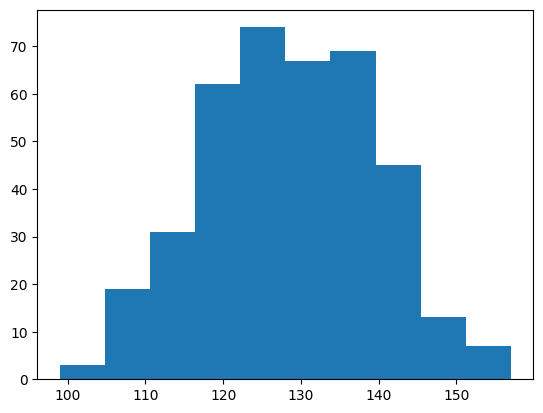

In [56]:
import matplotlib.pyplot as plt

batch_sizes = []
for x,y in dp_data_loader:
    batch_sizes.append(len(x))

plt.hist(batch_sizes)

## 1.c Custom Private Optimizer

Because of the variability, we can't infer the batch size from the input shape. And we need to know the batch size if we're averaging the gradients (with added noise) - under the DP assumptions sampling outcome (i.e. real batch size) does not affect the amount of noise added.

So we calculate expected batch size by looking at the data loader (it'll be the same as the batch size of the original data loader, we just need to make a few extra steps in case the original data loader was initialized with custom sampler).

In [57]:
from opacus.optimizers import DPOptimizer
from opacus.optimizers.optimizer import _check_processed_flag, _mark_as_processed
from torch.distributions.laplace import Laplace

sample_rate = 1 / len(data_loader)
expected_batch_size = int(len(data_loader.dataset) * sample_rate)

Many non-standard use cases will involve customizing the behaviour of `DPOptimizer`. We will customize this object to implement Laplace noise. By default, the noise added is Gaussian. To do this, we need to modify the `add_noise` method.

See this image for an overiview of how the DPOOptimizer functions: https://github.com/pytorch/opacus/blob/main/tutorials/img/optimizer.png

### Question 2. What should be the loc and scale of the Laplace noise below as a function of `self.noise_multiplier` and `self.max_grad_norm` (1 point)

In [58]:
# Define a non-private optimizer
optimizer = torch.optim.SGD(head.parameters(), lr=0.3, momentum=0.9, nesterov=True)


# Define a custom class which adds laplace noise
class LaplaceDPOptimizer(DPOptimizer):
    def clip_and_accumulate(self):
        """
        Performs gradient clipping.
        Stores clipped and aggregated gradients into `p.summed_grad```
        """

        if len(self.grad_samples[0]) == 0:
            # Empty batch
            per_sample_clip_factor = torch.zeros(
                (0,), device=self.grad_samples[0].device
            )
        else:
            per_param_norms = [
                g.reshape(len(g), -1).norm(1, dim=-1) for g in self.grad_samples
            ]
            per_sample_norms = torch.stack(per_param_norms, dim=1).norm(1, dim=1)
            per_sample_clip_factor = (
                self.max_grad_norm / (per_sample_norms + 1e-6)
            ).clamp(max=1.0)

        for p in self.params:
            _check_processed_flag(p.grad_sample)
            grad_sample = self._get_flat_grad_sample(p)
            grad = torch.einsum("i,i...", per_sample_clip_factor, grad_sample)

            if p.summed_grad is not None:
                p.summed_grad += grad
            else:
                p.summed_grad = grad

            _mark_as_processed(p.grad_sample)

    def add_noise(self):
        # FILL IN BELOW.
        # COMPUTE `loc` and `scale` as a function of `self.noise_multiplier` and `self.max_grad_norm`
        laplace = Laplace(loc= 0 , scale= self.noise_multiplier * self.max_grad_norm/self.expected_batch_size)
        for p in self.params:
            _check_processed_flag(p.summed_grad)

            noise = laplace.sample(p.summed_grad.shape)
            # becuse grad may be on GPU, we need send noise to GPU
            noise = noise.to(p.summed_grad.device)
            p.grad = p.summed_grad + noise

            _mark_as_processed(p.summed_grad)


# Convert our non-private optimizer to a private one
optimizer = LaplaceDPOptimizer(
    optimizer=optimizer,
    noise_multiplier=1.0,
    max_grad_norm=1.0,
    expected_batch_size=expected_batch_size,
)

## 1.d Privacy Accounting

And now the final (and most important) piece of the puzzle - privacy accounting. We will define an accountant for our Laplace mechanism.

Let us first write a function which computes the privacy parameter ɛ.

### Question 3. Given history (list of values of `noise_multiplier` and `q`), compute epsilon (2 points)

In [59]:
from typing import List, Tuple
import math
def compute_eps(
    history: List[Tuple[float, float, int]]
) -> float:
    r"""Computes Differential Privacy guarantees of the
    Sampled Laplace Mechanism (SLM) given history.

    Args: history which is a list of (q,noise_multiplier,step)
        noise_multiplier: The ratio of the additive Laplacian noise parameter
            to the L1-sensitivity of the function
            to which it is added.
        q: Sampling rate of SLM.
        step: Current iteration step.

    Returns:
        The float value of epislon for pure DP
    """
    epsilon = 0.0
    for noise_multiplier, q, step in history:
        # FILL IN HERE LOGIC TO COMPUTE EPSILON
        b = 1 / noise_multiplier
        epsilon_tilde = math. log (1 - q + q * math. exp(b))
        epsilon += epsilon_tilde
    return epsilon

Now we will customize the abstract class of `IAccountant` to implement our custom LaplacianAccountant

In [60]:
from opacus.accountants.accountant import IAccountant

class LaplacianAccountant(IAccountant):
    def __init__(self):
        super().__init__()

    def step(self, *, noise_multiplier: float, sample_rate: float):
        if len(self.history) >= 1:
            step_num = self.history[-1][-1]
            self.history.append((noise_multiplier, sample_rate, step_num + 1))
        else:
            self.history = [(noise_multiplier, sample_rate, 1)]

    def get_epsilon(self, delta: float = 0, poisson: bool = True) -> float:
        """
        Return privacy budget (epsilon) expended so far.

        Args:
            delta: this is always 0 for Laplace mechanism
            poisson: ``True`` is input batches was sampled via Poisson sampling,
                ``False`` otherwise
        """
        assert delta == 0, "Laplace mechanism does not support delta"
        assert poisson, "Our mechanism only supports Poisson sampling"

        return compute_eps(self.history)

    def __len__(self):
        return len(self.history)

    @classmethod
    def mechanism(cls) -> str:
        return "lap"

We now need to do is to initialize the accountant object and attach it to track `DPOptimizer`

In [61]:
accountant = LaplacianAccountant()
optimizer.attach_step_hook(accountant.get_optimizer_hook_fn(sample_rate=sample_rate))

# Part 2: Finally, train the model!

Let us write code to train for 1 epoch

In [62]:
import numpy as np
from opacus.utils.batch_memory_manager import BatchMemoryManager

def accuracy(preds, labels):
    return (preds == labels).mean()

def train(backbone, head, optimizer, train_loader, epoch=1, verbose=True):
    top1_accs = []
    losses = []
    criterion = nn.CrossEntropyLoss()
    head.train()
    backbone.train()
    with BatchMemoryManager(
        data_loader=train_loader,
        max_physical_batch_size=BATCH_SIZE,
        optimizer=optimizer
    ) as memory_safe_data_loader:
        for i, (x, y) in  tqdm(enumerate(memory_safe_data_loader), desc="Step", unit="step"):
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)

            # compute output
            with torch.no_grad():
                x = backbone(x)

            logits = head(x)
            loss = criterion(logits, y)

            preds = np.argmax(logits.detach().cpu().numpy(), axis=1)
            labels = y.detach().cpu().numpy()

            # measure accuracy and record loss
            acc = accuracy(preds, labels)
            losses.append(loss.item())
            top1_accs.append(acc)

            # compute update
            loss.backward()
            optimizer.step()
            if i % 50 == 0 and verbose:
                epsilon = accountant.get_epsilon()
                print(
                    f"\tTrain Epoch: {epoch} \t"
                    f"Step: {i} \t"
                    f"Loss: {np.mean(losses):.6f} "
                    f"Acc@1: {np.mean(top1_accs) * 100:.6f} "
                    f"(ε = {epsilon:.2f})"
                )

    return

Next, we will create a function to validate on our test dataset

In [63]:
def test(head, backbone, test_loader):
    head.eval()
    backbone.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            x = backbone(x)
            output = head(x)
            loss = criterion(output, y)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = y.detach().cpu().numpy()
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)

    print(
        f"\tTest set:"
        f"Loss: {np.mean(losses):.6f} "
        f"Acc: {top1_avg * 100:.6f} "
    )
    return np.mean(top1_acc)

In [64]:
for epoch in tqdm(range(10), desc="Epoch", unit="epoch"):
    train(backbone, head, optimizer, train_loader, epoch+1)
test(head, backbone, test_loader)

Epoch:   0%|          | 0/10 [00:00<?, ?epoch/s]

Step: 0step [00:00, ?step/s]

	Train Epoch: 1 	Step: 0 	Loss: 2.873094 Acc@1: 7.031250 (ε = 0.00)
	Train Epoch: 1 	Step: 50 	Loss: 2.521996 Acc@1: 11.780025 (ε = 0.22)
	Train Epoch: 1 	Step: 100 	Loss: 2.428685 Acc@1: 13.056931 (ε = 0.44)
	Train Epoch: 1 	Step: 150 	Loss: 2.370153 Acc@1: 14.616101 (ε = 0.66)
	Train Epoch: 1 	Step: 200 	Loss: 2.325880 Acc@1: 16.060323 (ε = 0.88)
	Train Epoch: 1 	Step: 250 	Loss: 2.288325 Acc@1: 17.548556 (ε = 1.10)
	Train Epoch: 1 	Step: 300 	Loss: 2.255892 Acc@1: 18.825270 (ε = 1.32)
	Train Epoch: 1 	Step: 350 	Loss: 2.229814 Acc@1: 20.012019 (ε = 1.54)


Step: 0step [00:00, ?step/s]

	Train Epoch: 2 	Step: 0 	Loss: 1.999333 Acc@1: 28.125000 (ε = 1.72)
	Train Epoch: 2 	Step: 50 	Loss: 1.990813 Acc@1: 30.836397 (ε = 1.94)
	Train Epoch: 2 	Step: 100 	Loss: 1.971148 Acc@1: 31.783725 (ε = 2.16)
	Train Epoch: 2 	Step: 150 	Loss: 1.960285 Acc@1: 31.839818 (ε = 2.38)
	Train Epoch: 2 	Step: 200 	Loss: 1.947360 Acc@1: 32.210044 (ε = 2.60)
	Train Epoch: 2 	Step: 250 	Loss: 1.932175 Acc@1: 32.877864 (ε = 2.82)
	Train Epoch: 2 	Step: 300 	Loss: 1.920141 Acc@1: 33.323816 (ε = 3.04)
	Train Epoch: 2 	Step: 350 	Loss: 1.909354 Acc@1: 33.847489 (ε = 3.26)


Step: 0step [00:00, ?step/s]

	Train Epoch: 3 	Step: 0 	Loss: 1.803063 Acc@1: 36.718750 (ε = 3.44)
	Train Epoch: 3 	Step: 50 	Loss: 1.800517 Acc@1: 38.388480 (ε = 3.66)
	Train Epoch: 3 	Step: 100 	Loss: 1.786200 Acc@1: 38.830446 (ε = 3.88)
	Train Epoch: 3 	Step: 150 	Loss: 1.781556 Acc@1: 39.015935 (ε = 4.10)
	Train Epoch: 3 	Step: 200 	Loss: 1.772902 Acc@1: 39.097481 (ε = 4.32)
	Train Epoch: 3 	Step: 250 	Loss: 1.762915 Acc@1: 39.274153 (ε = 4.54)
	Train Epoch: 3 	Step: 300 	Loss: 1.756170 Acc@1: 39.449232 (ε = 4.76)
	Train Epoch: 3 	Step: 350 	Loss: 1.751000 Acc@1: 39.625623 (ε = 4.98)


Step: 0step [00:00, ?step/s]

	Train Epoch: 4 	Step: 0 	Loss: 1.694033 Acc@1: 33.593750 (ε = 5.16)
	Train Epoch: 4 	Step: 50 	Loss: 1.688306 Acc@1: 41.835172 (ε = 5.38)
	Train Epoch: 4 	Step: 100 	Loss: 1.674640 Acc@1: 42.056002 (ε = 5.60)
	Train Epoch: 4 	Step: 150 	Loss: 1.675524 Acc@1: 41.892591 (ε = 5.82)
	Train Epoch: 4 	Step: 200 	Loss: 1.670711 Acc@1: 41.837687 (ε = 6.04)
	Train Epoch: 4 	Step: 250 	Loss: 1.664031 Acc@1: 41.991409 (ε = 6.26)
	Train Epoch: 4 	Step: 300 	Loss: 1.660724 Acc@1: 42.034365 (ε = 6.48)
	Train Epoch: 4 	Step: 350 	Loss: 1.658643 Acc@1: 42.167468 (ε = 6.70)


Step: 0step [00:00, ?step/s]

	Train Epoch: 5 	Step: 0 	Loss: 1.639057 Acc@1: 40.625000 (ε = 6.88)
	Train Epoch: 5 	Step: 50 	Loss: 1.618440 Acc@1: 43.857230 (ε = 7.10)
	Train Epoch: 5 	Step: 100 	Loss: 1.609666 Acc@1: 43.873762 (ε = 7.32)
	Train Epoch: 5 	Step: 150 	Loss: 1.611304 Acc@1: 43.781043 (ε = 7.54)
	Train Epoch: 5 	Step: 200 	Loss: 1.607080 Acc@1: 43.800529 (ε = 7.76)
	Train Epoch: 5 	Step: 250 	Loss: 1.600233 Acc@1: 44.095493 (ε = 7.98)
	Train Epoch: 5 	Step: 300 	Loss: 1.597283 Acc@1: 44.157496 (ε = 8.20)
	Train Epoch: 5 	Step: 350 	Loss: 1.596502 Acc@1: 44.197382 (ε = 8.42)


Step: 0step [00:00, ?step/s]

	Train Epoch: 6 	Step: 0 	Loss: 1.558333 Acc@1: 40.625000 (ε = 8.60)
	Train Epoch: 6 	Step: 50 	Loss: 1.568190 Acc@1: 44.761029 (ε = 8.82)
	Train Epoch: 6 	Step: 100 	Loss: 1.556969 Acc@1: 45.188738 (ε = 9.04)
	Train Epoch: 6 	Step: 150 	Loss: 1.557193 Acc@1: 45.058982 (ε = 9.26)
	Train Epoch: 6 	Step: 200 	Loss: 1.553710 Acc@1: 45.129820 (ε = 9.48)
	Train Epoch: 6 	Step: 250 	Loss: 1.546260 Acc@1: 45.384089 (ε = 9.70)
	Train Epoch: 6 	Step: 300 	Loss: 1.543447 Acc@1: 45.460444 (ε = 9.92)
	Train Epoch: 6 	Step: 350 	Loss: 1.543734 Acc@1: 45.443821 (ε = 10.14)


Step: 0step [00:00, ?step/s]

	Train Epoch: 7 	Step: 0 	Loss: 1.534629 Acc@1: 36.718750 (ε = 10.32)
	Train Epoch: 7 	Step: 50 	Loss: 1.526318 Acc@1: 46.369485 (ε = 10.54)
	Train Epoch: 7 	Step: 100 	Loss: 1.516558 Acc@1: 46.689356 (ε = 10.76)
	Train Epoch: 7 	Step: 150 	Loss: 1.519905 Acc@1: 46.290356 (ε = 10.98)
	Train Epoch: 7 	Step: 200 	Loss: 1.516823 Acc@1: 46.334733 (ε = 11.20)
	Train Epoch: 7 	Step: 250 	Loss: 1.510951 Acc@1: 46.526394 (ε = 11.42)
	Train Epoch: 7 	Step: 300 	Loss: 1.510630 Acc@1: 46.522010 (ε = 11.64)
	Train Epoch: 7 	Step: 350 	Loss: 1.511212 Acc@1: 46.492165 (ε = 11.86)


Step: 0step [00:00, ?step/s]

	Train Epoch: 8 	Step: 0 	Loss: 1.506858 Acc@1: 39.843750 (ε = 12.04)
	Train Epoch: 8 	Step: 50 	Loss: 1.490512 Acc@1: 47.472426 (ε = 12.26)
	Train Epoch: 8 	Step: 100 	Loss: 1.481463 Acc@1: 47.741337 (ε = 12.48)
	Train Epoch: 8 	Step: 150 	Loss: 1.486638 Acc@1: 47.542425 (ε = 12.70)
	Train Epoch: 8 	Step: 200 	Loss: 1.483874 Acc@1: 47.539646 (ε = 12.92)
	Train Epoch: 8 	Step: 250 	Loss: 1.477042 Acc@1: 47.743401 (ε = 13.14)
	Train Epoch: 8 	Step: 300 	Loss: 1.476467 Acc@1: 47.689992 (ε = 13.36)
	Train Epoch: 8 	Step: 350 	Loss: 1.477657 Acc@1: 47.700766 (ε = 13.58)


Step: 0step [00:00, ?step/s]

	Train Epoch: 9 	Step: 0 	Loss: 1.470968 Acc@1: 42.187500 (ε = 13.76)
	Train Epoch: 9 	Step: 50 	Loss: 1.465886 Acc@1: 48.299632 (ε = 13.98)
	Train Epoch: 9 	Step: 100 	Loss: 1.459154 Acc@1: 48.367884 (ε = 14.20)
	Train Epoch: 9 	Step: 150 	Loss: 1.465042 Acc@1: 48.101200 (ε = 14.42)
	Train Epoch: 9 	Step: 200 	Loss: 1.462732 Acc@1: 48.107121 (ε = 14.63)
	Train Epoch: 9 	Step: 250 	Loss: 1.456349 Acc@1: 48.316111 (ε = 14.85)
	Train Epoch: 9 	Step: 300 	Loss: 1.455817 Acc@1: 48.328488 (ε = 15.07)
	Train Epoch: 9 	Step: 350 	Loss: 1.456871 Acc@1: 48.339566 (ε = 15.29)


Step: 0step [00:00, ?step/s]

	Train Epoch: 10 	Step: 0 	Loss: 1.418920 Acc@1: 43.750000 (ε = 15.47)
	Train Epoch: 10 	Step: 50 	Loss: 1.450629 Acc@1: 49.080882 (ε = 15.69)
	Train Epoch: 10 	Step: 100 	Loss: 1.442406 Acc@1: 49.195545 (ε = 15.91)
	Train Epoch: 10 	Step: 150 	Loss: 1.447470 Acc@1: 48.644454 (ε = 16.13)
	Train Epoch: 10 	Step: 200 	Loss: 1.445356 Acc@1: 48.596859 (ε = 16.35)
	Train Epoch: 10 	Step: 250 	Loss: 1.438147 Acc@1: 48.851469 (ε = 16.57)
	Train Epoch: 10 	Step: 300 	Loss: 1.437417 Acc@1: 48.819041 (ε = 16.79)
	Train Epoch: 10 	Step: 350 	Loss: 1.438661 Acc@1: 48.838141 (ε = 17.01)
	Test set:Loss: 1.429658 Acc: 49.258307 


0.49258306962025317

### Question 4. There is a fundamental mistake in the above implementation. We clip L2 norm, whereas we should have clipped L1 norm. Fix this (2 points)

To fix this, you will have to override the `clip_and_accumulate()` method of the `DPOptimizer` class when implementing `LaplaceDPOptimizer`. Copy the default implementaion from [here](https://github.com/pytorch/opacus/blob/a246aa644bc9f04aaf17faa5706efb145a7c6ac7/opacus/optimizers/optimizer.py#L429C9-L429C28) and edit what is required to change from L2 norm to L1 norm.

Re-run your code. What happens to the convergence?

**Answer:** This change leads to more slower convergence and lower accuracy. Because L1 norm has less stable gradient updates. And L1 norm clipping is more sensitive to individual components of the gradient, leading to adding more noise in the estimator and slowing convergence.